## Topic Modeling Tweets

Using tweets with the hashtag #micropoetry to better understand the popularity of poetic topics in the post internet age.

Import stuff: os and glob for files, numpy and sklearn for math, matplotlib for plotting, operator for sorting, pandas for CSV reading, and re for tweet cleaning.

In [60]:
%matplotlib inline
import os
import glob
import numpy as np
import sklearn.feature_extraction.text as text
from sklearn import decomposition
import matplotlib.pyplot as plt
import operator
import pandas as pd
import re

Put tweets file names in a sorted list.

In [61]:
filenames = sorted(glob.glob('twitter/Individual Tweets/*'))

There are 7668 individual files/tweets.

In [62]:
print(len(filenames))

7668


Let's check the first 5 tweets.

In [63]:
print(filenames[:5])

['twitter/Individual Tweets/00001.txt', 'twitter/Individual Tweets/00002.txt', 'twitter/Individual Tweets/00003.txt', 'twitter/Individual Tweets/00004.txt', 'twitter/Individual Tweets/00005.txt']


Convert the collection of text documents to a matrix of token counts:

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [64]:
vectorizer = text.CountVectorizer(input='filename', stop_words='english', min_df=20)

Documentation on fit_transform and get_feature_names:

http://scikit-learn.org/stable/modules/feature_extraction.html

In [65]:
dtm = vectorizer.fit_transform(filenames).toarray()

In [66]:
vocab = np.array(vectorizer.get_feature_names())

Check the shape of the vector.

In [67]:
print(dtm.shape)

(7668, 492)


Set how many topics we want.

In [68]:
num_topics = 10

Set how many words we want in each topic.

In [69]:
num_top_words = 20

Non-Negative Matrix Factorization (NMF)

Find two non-negative matrices (W, H) whose product approximates the non-negative matrix X.

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [70]:
clf = decomposition.NMF(n_components=num_topics, random_state=1)

In [71]:
doctopic = clf.fit_transform(dtm)

In [72]:
topic_words = []

In [73]:
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

In [74]:
doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

Make an empty list.

In [75]:
tweet_names = []

Fill the list with file names.

In [76]:
for fn in filenames:
    basename = os.path.basename(fn)
    name, ext = os.path.splitext(basename)
    tweet_names.append(name)

Make the list an array.

In [77]:
tweet_names = np.asarray(tweet_names)

In [78]:
doctopic_orig = doctopic.copy()

In [79]:
num_groups = len(set(tweet_names))

In [80]:
doctopic_grouped = np.zeros((num_groups, num_topics))

In [81]:
for i, name in enumerate(sorted(set(tweet_names))):
    doctopic_grouped[i, :] = np.mean(doctopic[tweet_names == name, :], axis=0)

In [82]:
doctopic = doctopic_grouped

In [83]:
tweets = sorted(set(tweet_names))

In [84]:
d = {}
for i in range(len(doctopic)):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:1]
    top_topics_str = ' '.join(str(t) for t in top_topics)
    d[tweets[i]] = top_topics_str
    #print("{}: {}".format(tweets[i], top_topics_str))
s = sorted(d.items(), key=operator.itemgetter(0))

Open up a comma-separated values sheet.

In [85]:
micro_poems_csv = pd.read_csv('micro_poetry.csv', header=True, encoding='latin1')

In [86]:
len(micro_poems_csv)

21632

Make a dictionary out of it.

In [87]:
micro_poems_dict = micro_poems_csv.to_dict()

Make a list of tweets.

In [88]:
l = [value for key, value in micro_poems_dict["Tweet Text"].items()]

Clean up the tweets.

In [89]:
l2 = []
for tweet in l:
    tweet = tweet.replace("RT", "")
    tweet = ' '.join(re.sub("(\#[A-Za-z0-9_]+)|(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet).split())
    tweet = ' '.join(re.sub("( tco[A-Za-z0-9]+)", "", tweet).split())
    tweet = tweet.replace("https", "")
    tweet = tweet.replace("http", "")
    tweet = tweet.lower()
    l2.append(tweet)

Make a dictionary containing the tweets as keys and the number of occurrences as values

In [90]:
d = {}
for tweet in l2:
    if tweet not in d:
        d[tweet] = 1
    else:
        d[tweet] += 1

Make a list of file names.

In [91]:
l3 = [tup[0] for tup in s]

Make a list of favorites per tweet.

In [92]:
l4 = [value for key, value in micro_poems_dict["Favorites"].items()]

Make a list of top topics per tweet.

In [93]:
l5 = []
for tup in s:
    l5.append(tup[1])

Make a list of retweets per tweet.

In [94]:
l6 = [value for key, value in micro_poems_dict["Retweets"].items()]

Make a list of tuples, containing the top topic in a tweet and the number of favorites in that tweet.

In [95]:
s2 = list(zip(l5, l4))

Make a list of tuples, each containing the top topic in a tweet and the number of retweets in that tweet.

In [96]:
s3 = list(zip(l5, l6))

Plot the favorites per topic.

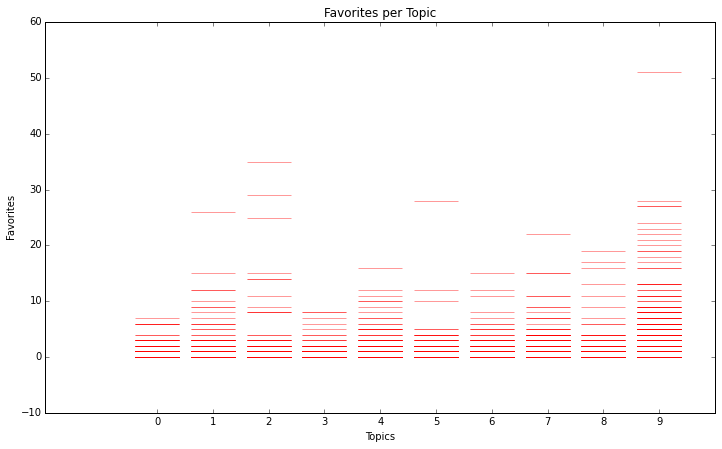

In [97]:
plt.figure(figsize=(12, 7))
plt.scatter(*zip(*s2), color='r', s=2000, marker='_', alpha=.4)
plt.xticks(np.arange(10))
plt.title('Favorites per Topic')
plt.xlabel('Topics')
plt.ylabel('Favorites')
plt.show()

Plot the retweets per topic.

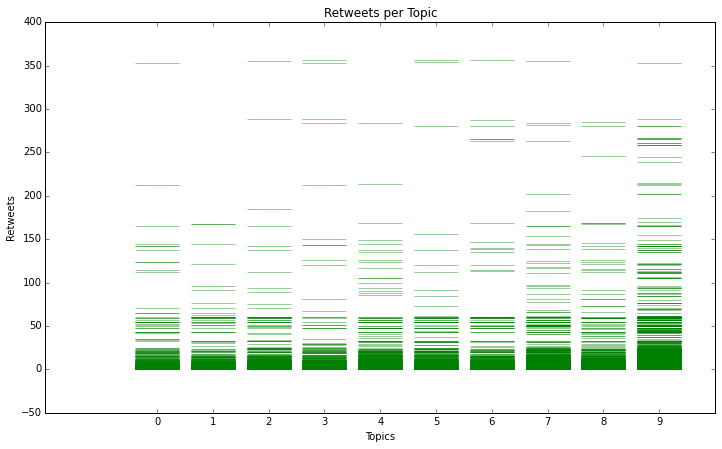

In [98]:
plt.figure(figsize=(12, 7))
plt.scatter(*zip(*s3), color='g', s=2000, marker='_', alpha=.4)
plt.xticks(np.arange(10))
plt.title('Retweets per Topic')
plt.xlabel('Topics')
plt.ylabel('Retweets')
plt.show()

Show the content of the topics.

In [99]:
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))

Topic 0: love true lost fall want touch old live lust feel lips poetry god matter theres
Topic 1: like feel god kiss words days wind warm wild thats look away sky honey soul
Topic 2: heart soul mind let words apart loves inside amp broken head song smile skin home
Topic 3: im youre going write afraid lost fast think good say quick home look verse need
Topic 4: life say things sit death reflect way old think right does man living hope change
Topic 5: just write verse bit little way wait ill light think away thats let want fast
Topic 6: time come way away day mind little place tea gone hearts rain let maybe distant
Topic 7: eyes words soul lips dreams smile world kiss look closed sleep tears away lost hold
Topic 8: know dont want need feel say youre going write let verse mind fast things happens
Topic 9: night day sky moon light sun winter rain morning wind cold stars clouds black leaves
